In [ ]:
##data= !wget https://data.cms.gov/sites/default/files/2024-03/663f0dab-d621-41c5-9130-dc9ce1beecf2/DSD_PTD_RY24_P04_V10_DY22_BGM.csv

In [ ]:
##import os
os.rename('DSD_PTD_RY24_P04_V10_DY22_BGM.csv', 'data.csv')

In [ ]:
# Decison Tree, Random Forest, and Balanced Random Forest
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import export_text
from sklearn.tree import _tree
import numpy as np
from collections import Counter
import itertools



# Fine tuning parameters
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


## K- Means
from sklearn.cluster import KMeans

# Basic Decision Tree

# Testing Diffirent Tree Depths to see interprebility and see how performance increases or decreases

In [ ]:
df = pd.read_csv('full_data.csv')

# Create % increase from 2018 to 2022
df['pct_increase_spending_18_22'] = (
    (df['Avg_Spnd_Per_Clm_2022'] - df['Avg_Spnd_Per_Clm_2018']) /
    df['Avg_Spnd_Per_Clm_2018']
) * 100

# Drop NaNs and Infs
df = df.dropna(subset=['pct_increase_spending_18_22'])
df = df[~df['pct_increase_spending_18_22'].isin([float('inf'), -float('inf')])]

# Define threshold and target
threshold = df['pct_increase_spending_18_22'].quantile(0.80)
df['is_high_cost'] = (df['pct_increase_spending_18_22'] >= threshold).astype(int)

# Select and encode features
features = [
    'Tot_Clms_2022',
    'Avg_Spnd_Per_Dsg_Unt_Wghtd_2022',
    'Chg_Avg_Spnd_Per_Dsg_Unt_21_22',
    'Class_Name',
    'Mftr_Name',
    'Gnrc_Name',
    'Brnd_Name'
]
df_model = df[features + ['is_high_cost']].dropna()
df_model = df_model[df_model['Mftr_Name'] != 'Overall']

df_encoded = pd.get_dummies(df_model, columns=['Class_Name', 'Mftr_Name', 'Gnrc_Name','Brnd_Name'], drop_first=True)

# Train/test split with scaling
X = df_encoded.drop(columns=['is_high_cost'])
y = df_encoded['is_high_cost']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42, stratify=y
)

# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42, max_depth=70)  ## 170 depth 0.71 recall # 80 0.65
dt_model.fit(X_train, y_train)

# Reports
y_pred_dt = dt_model.predict(X_test)
print("\n📋 Classification Report (Decision Tree):\n")
print(classification_report(y_test, y_pred_dt))



📋 Classification Report (Decision Tree):

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2441
           1       0.85      0.67      0.75       509

    accuracy                           0.92      2950
   macro avg       0.89      0.82      0.85      2950
weighted avg       0.92      0.92      0.92      2950



In [ ]:
df[['Tot_Clms_2022', 'Avg_Spnd_Per_Dsg_Unt_Wghtd_2022', 'Chg_Avg_Spnd_Per_Dsg_Unt_21_22','Class_Name','Mftr_Name', 'Gnrc_Name', 'Brnd_Name']].describe()

,Tot_Clms_2022,Avg_Spnd_Per_Dsg_Unt_Wghtd_2022,Chg_Avg_Spnd_Per_Dsg_Unt_21_22
count,1.756800e+04,17568.000000,17419.000000
mean,2.795985e+05,119.512997,0.070816
std,1.430100e+06,1147.644893,1.070093
min,1.100000e+01,0.003279,-0.946034
25%,5.027500e+02,0.483951,-0.031724
50%,5.309000e+03,1.722040,0.017187
75%,6.854500e+04,12.124273,0.072472
max,6.479730e+07,39401.850470,64.750206


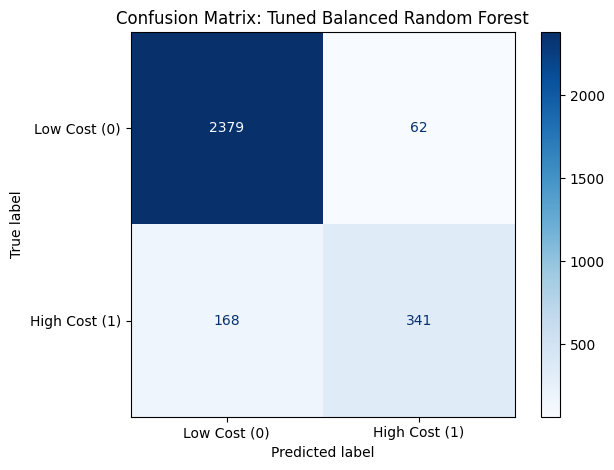

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Cost (0)", "High Cost (1)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Tuned Balanced Random Forest")
plt.tight_layout()
plt.show()


# Checking out rules and seeing what combos populate also shows splits and hoq it classifies Class 1 and Class 2

In [ ]:
feature_names = X.columns
tree_rules = export_text(dt_model, feature_names=list(feature_names))
print(tree_rules)


|--- Chg_Avg_Spnd_Per_Dsg_Unt_21_22 <= -0.04
|   |--- Mftr_Name_Actavis/Allerga <= 7.79
|   |   |--- Brnd_Name_Meclofenamate Sodium <= 9.68
|   |   |   |--- Mftr_Name_Upsher Smith La <= 8.22
|   |   |   |   |--- Brnd_Name_Folic Acid* <= 10.08
|   |   |   |   |   |--- Mftr_Name_Sunrise Pharmac <= 13.72
|   |   |   |   |   |   |--- Mftr_Name_Time-Cap Labs <= 11.99
|   |   |   |   |   |   |   |--- Brnd_Name_Viread <= 17.51
|   |   |   |   |   |   |   |   |--- Brnd_Name_Kenalog-40 <= 17.51
|   |   |   |   |   |   |   |   |   |--- Brnd_Name_Naproxen <= 5.34
|   |   |   |   |   |   |   |   |   |   |--- Brnd_Name_Nuvessa <= 17.51
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 60
|   |   |   |   |   |   |   |   |   |   |--- Brnd_Name_Nuvessa >  17.51
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- Brnd_Name_Naproxen >  5.34
|   |   |   |   |   |   |   |   |   |   |--- Tot_Clms_2022 <= -0.26
|   |   |   |   |   |   |

# Gets decision tree rules from the model, however the rules are a bit black box as the depth of the trees are big because of categorical variables

In [ ]:
def extract_rules(tree_model, feature_names, target_class=1, top_n=30):
    tree_ = tree_model.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    rules = []

    def recurse(node, depth, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # Left child
            recurse(tree_.children_left[node], depth + 1,
                    path + [f"{name} <= {threshold:.2f}"])
            # Right child
            recurse(tree_.children_right[node], depth + 1,
                    path + [f"{name} > {threshold:.2f}"])
        else:
            value = tree_.value[node][0]
            predicted_class = np.argmax(value)
            support = int(np.sum(value))
            if predicted_class == target_class:
                rules.append({
                    "rule": " AND ".join(path),
                    "samples": support,
                    "confidence": value[target_class] / support if support else 0
                })

    recurse(0, 1, [])

    # Sort by number of samples (descending)
    sorted_rules = sorted(rules, key=lambda x: x["samples"], reverse=True)
    return pd.DataFrame(sorted_rules[:top_n])

# 📌 Use this AFTER training your decision tree
top_rules_df = extract_rules(dt_model, list(X.columns), target_class=1, top_n=30)
top_rules_df



,rule,samples,confidence
0,Chg_Avg_Spnd_Per_Dsg_Unt_21_22 <= -0.04 AND Mf...,1,1.0
1,Chg_Avg_Spnd_Per_Dsg_Unt_21_22 <= -0.04 AND Mf...,1,1.0
2,Chg_Avg_Spnd_Per_Dsg_Unt_21_22 <= -0.04 AND Mf...,1,1.0
3,Chg_Avg_Spnd_Per_Dsg_Unt_21_22 <= -0.04 AND Mf...,1,1.0
4,Chg_Avg_Spnd_Per_Dsg_Unt_21_22 <= -0.04 AND Mf...,1,1.0
5,Chg_Avg_Spnd_Per_Dsg_Unt_21_22 <= -0.04 AND Mf...,1,1.0
6,Chg_Avg_Spnd_Per_Dsg_Unt_21_22 <= -0.04 AND Mf...,1,1.0
7,Chg_Avg_Spnd_Per_Dsg_Unt_21_22 <= -0.04 AND Mf...,1,1.0
8,Chg_Avg_Spnd_Per_Dsg_Unt_21_22 <= -0.04 AND Mf...,1,1.0
9,Chg_Avg_Spnd_Per_Dsg_Unt_21_22 <= -0.04 AND Mf...,1,1.0


# Picks out individual variables the appear the most often and then the variable combinations that appear the most

In [ ]:
# Step 1: Break all rules into individual conditions
all_conditions = []
for rule in top_rules_df['rule']:
    conditions = rule.split(" AND ")
    all_conditions.extend(conditions)

# Step 2: Count frequency of each condition
condition_counts = Counter(all_conditions)

# Step 3: Count co-occurrence of condition pairs within the same rule
pair_counts = Counter()
for rule in top_rules_df['rule']:
    conditions = rule.split(" AND ")
    for combo in itertools.combinations(set(conditions), 2):
        pair_counts[frozenset(combo)] += 1

# Step 4: Most common single conditions
top_conditions = pd.DataFrame(condition_counts.most_common(20), columns=['condition', 'count'])
print("🔝 Top 20 Most Common Individual Conditions:")
print(top_conditions)

# Step 5: Most common pairs of conditions
top_pairs = pd.DataFrame(
    [(list(pair)[0] + " + " + list(pair)[1], count) for pair, count in pair_counts.most_common(20)],
    columns=['condition_pair', 'count']
)
print("\n🔗 Top 20 Most Common Condition Pairs:")
top_pairs


🔝 Top 20 Most Common Individual Conditions:
                                  condition  count
0   Chg_Avg_Spnd_Per_Dsg_Unt_21_22 <= -0.04     30
1         Mftr_Name_Actavis/Allerga <= 7.79     30
2    Brnd_Name_Meclofenamate Sodium <= 9.68     30
3         Mftr_Name_Upsher Smith La <= 8.22     30
4            Brnd_Name_Folic Acid* <= 10.08     30
5        Mftr_Name_Sunrise Pharmac <= 13.72     30
6          Mftr_Name_Time-Cap Labs <= 11.99     30
7                 Brnd_Name_Viread <= 17.51     30
8             Brnd_Name_Kenalog-40 <= 17.51     30
9                Brnd_Name_Naproxen <= 5.34     30
10               Brnd_Name_Nuvessa <= 17.51     30
11        Mftr_Name_App/Premierpro <= 11.65     30
12       Mftr_Name_Validus Pharmac <= 18.72     30
13                   Tot_Clms_2022 <= -0.26     28
14  Class_Name_Other antiepileptics <= 4.88     11
15                    Tot_Clms_2022 > -0.26     11
16   Chg_Avg_Spnd_Per_Dsg_Unt_21_22 > -0.15     11
17  Chg_Avg_Spnd_Per_Dsg_Unt_21_22 <= 

,condition_pair,count
0,Brnd_Name_Naproxen <= 5.34 + Brnd_Name_Nuvessa...,30
1,Mftr_Name_Sunrise Pharmac <= 13.72 + Brnd_Name...,30
2,Brnd_Name_Kenalog-40 <= 17.51 + Brnd_Name_Nuve...,30
3,Mftr_Name_Validus Pharmac <= 18.72 + Brnd_Name...,30
4,Mftr_Name_Actavis/Allerga <= 7.79 + Brnd_Name_...,30
5,Brnd_Name_Folic Acid* <= 10.08 + Brnd_Name_Nuv...,30
6,Chg_Avg_Spnd_Per_Dsg_Unt_21_22 <= -0.04 + Brnd...,30
7,Mftr_Name_Time-Cap Labs <= 11.99 + Brnd_Name_N...,30
8,Brnd_Name_Meclofenamate Sodium <= 9.68 + Brnd_...,30
9,Mftr_Name_Upsher Smith La <= 8.22 + Brnd_Name_...,30


<ipython-input-28-2bba2c7a9227>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='condition', data=top_conditions, ax=ax1, palette='Blues_d')


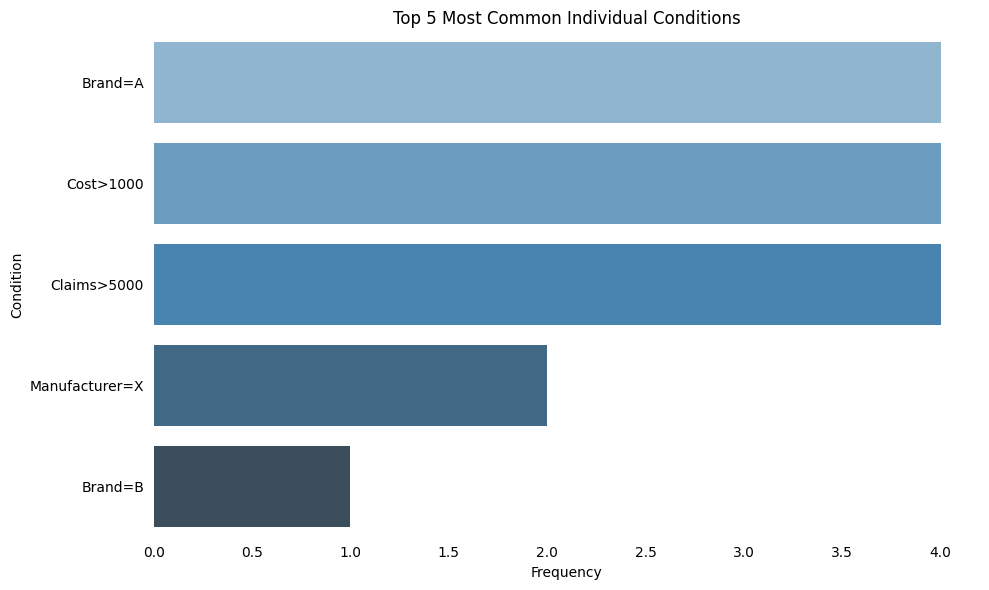

<ipython-input-28-2bba2c7a9227>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='condition_pair', data=top_pairs, ax=ax2, palette='Greens_d')


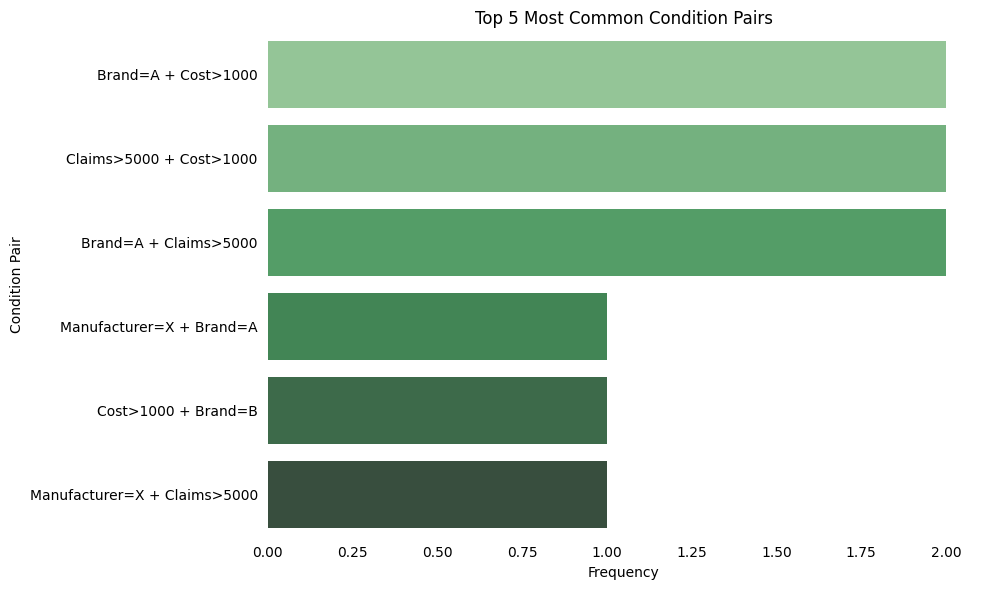

In [ ]:
# Sample input: replace with your actual top_rules_df
top_rules_df = pd.DataFrame({
    'rule': [
        "Brand=A AND Cost>1000",
        "Brand=A AND Manufacturer=X",
        "Cost>1000 AND Claims>5000",
        "Brand=A AND Claims>5000",
        "Brand=B AND Cost>1000",
        "Manufacturer=X AND Claims>5000",
        "Brand=A AND Cost>1000 AND Claims>5000"
    ]
})

# Step 1–3: Prepare condition counts
all_conditions = []
for rule in top_rules_df['rule']:
    conditions = rule.split(" AND ")
    all_conditions.extend(conditions)

condition_counts = Counter(all_conditions)

pair_counts = Counter()
for rule in top_rules_df['rule']:
    conditions = rule.split(" AND ")
    for combo in itertools.combinations(set(conditions), 2):
        pair_counts[frozenset(combo)] += 1

top_conditions = pd.DataFrame(condition_counts.most_common(20), columns=['condition', 'count'])
top_pairs = pd.DataFrame(
    [(list(pair)[0] + " + " + list(pair)[1], count) for pair, count in pair_counts.most_common(20)],
    columns=['condition_pair', 'count']
)

# Helper: remove plot borders
def remove_spines(ax):
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(top=False, right=False, left=False, bottom=False)

# Plot 1: Individual Conditions
fig1, ax1 = plt.subplots(figsize=(10, 6), facecolor='none')
sns.barplot(x='count', y='condition', data=top_conditions, ax=ax1, palette='Blues_d')
ax1.set_facecolor('none')
fig1.patch.set_alpha(0)
remove_spines(ax1)
plt.title('Top 5 Most Common Individual Conditions')
plt.xlabel('Frequency')
plt.ylabel('Condition')
plt.tight_layout()
plt.savefig("top_individual_conditions.png", transparent=True, dpi=300)
plt.show()

# Plot 2: Condition Pairs
fig2, ax2 = plt.subplots(figsize=(10, 6), facecolor='none')
sns.barplot(x='count', y='condition_pair', data=top_pairs, ax=ax2, palette='Greens_d')
ax2.set_facecolor('none')
fig2.patch.set_alpha(0)
remove_spines(ax2)
plt.title('Top 5 Most Common Condition Pairs')
plt.xlabel('Frequency')
plt.ylabel('Condition Pair')
plt.tight_layout()
plt.savefig("top_condition_pairs.png", transparent=True, dpi=300)
plt.show()


# Random Forest

In [ ]:
# Train the Random Forest model default paramters
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("\n📋 Classification Report (Random Forest):\n")
print(classification_report(y_test, y_pred_rf))



📋 Classification Report (Random Forest):

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2441
           1       0.94      0.64      0.76       509

    accuracy                           0.93      2950
   macro avg       0.94      0.82      0.86      2950
weighted avg       0.93      0.93      0.93      2950



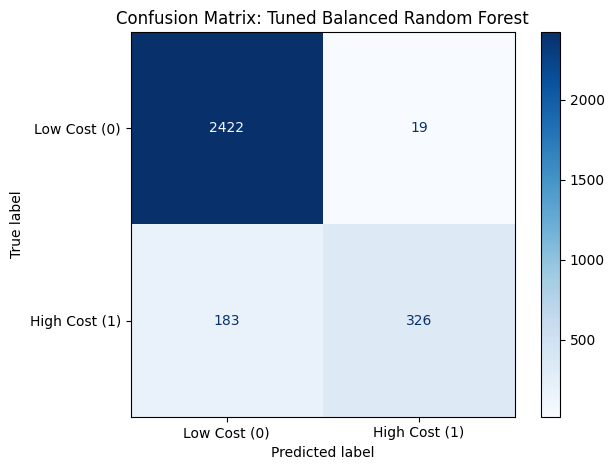

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Cost (0)", "High Cost (1)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Tuned Balanced Random Forest")
plt.tight_layout()
plt.show()

# Price Gauging Warning Systems

# Balanced Random Forest Model


📋 Classification Report (Balanced Random Forest):

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2441
           1       0.73      0.83      0.78       509

    accuracy                           0.92      2950
   macro avg       0.85      0.89      0.86      2950
weighted avg       0.92      0.92      0.92      2950



<ipython-input-5-f62a909de90d>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=class_importance.head(10), palette='Reds_r')


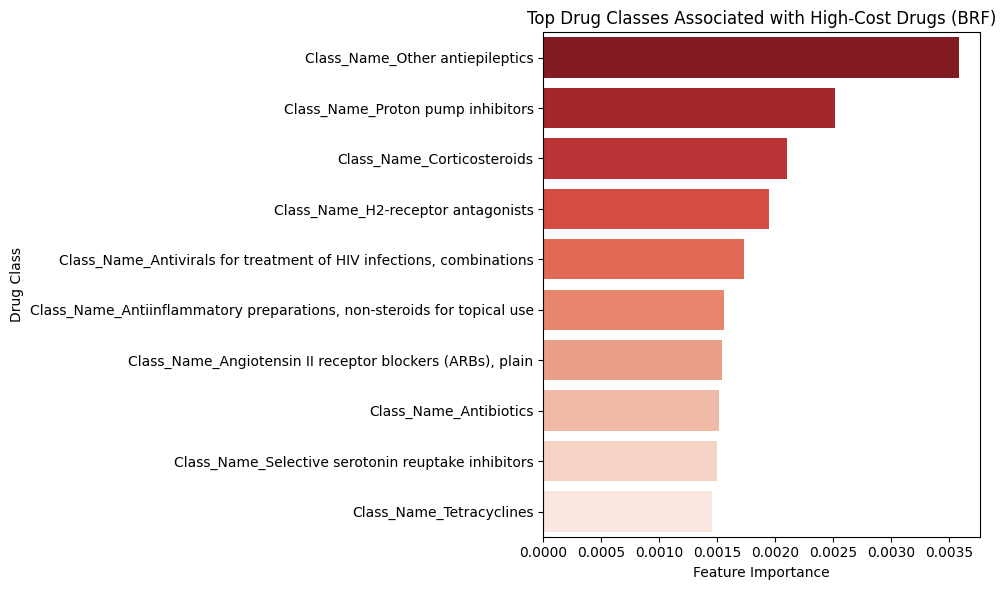

<ipython-input-5-f62a909de90d>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=mftr_importance.head(10), palette='Blues_r')


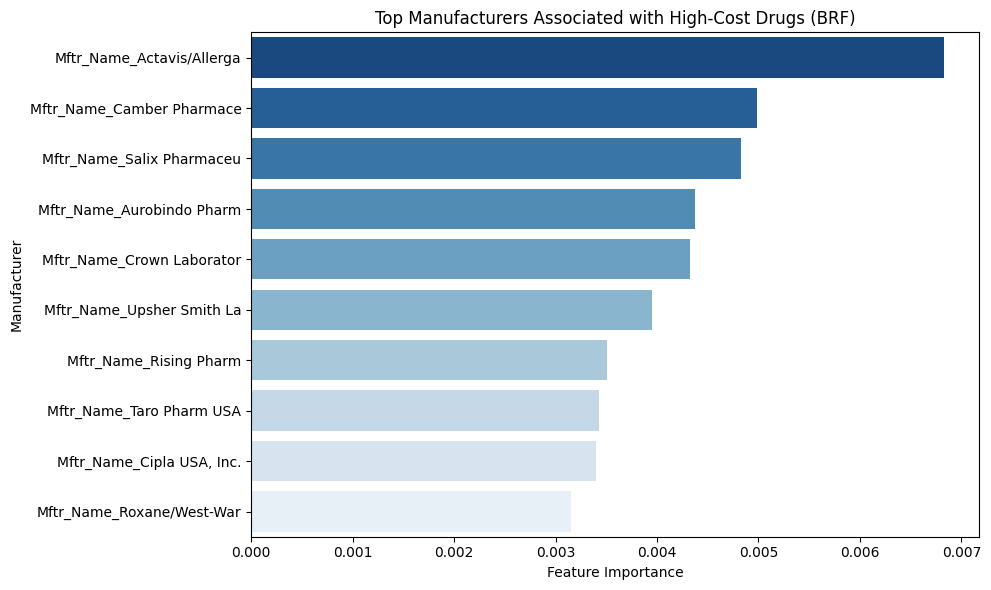

<ipython-input-5-f62a909de90d>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=gnrc_importance.head(10), palette='Blues_r')


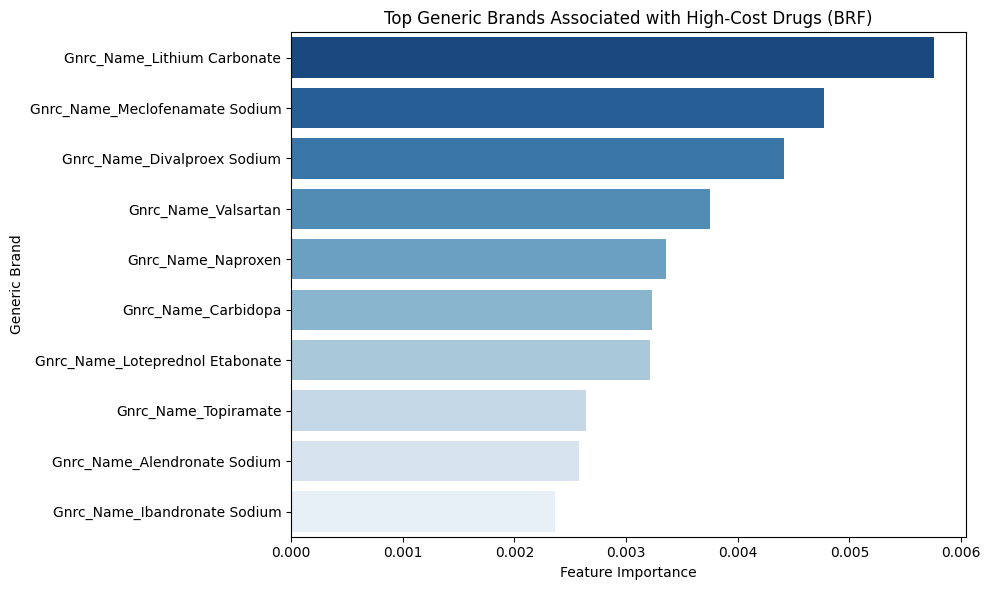

<ipython-input-5-f62a909de90d>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=brnd_importance.head(10), palette='Blues_r')


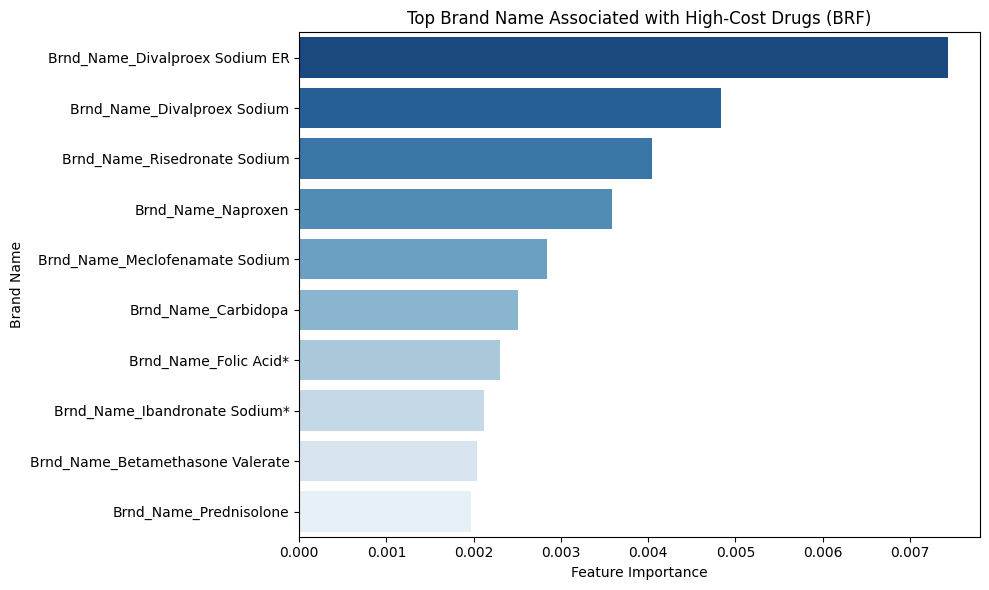

In [ ]:
df=pd.read_csv('full_data.csv')

# Create % increase from 2018 to 2022
df['pct_increase_spending_18_22'] = (
    (df['Avg_Spnd_Per_Clm_2022'] - df['Avg_Spnd_Per_Clm_2018']) /
    df['Avg_Spnd_Per_Clm_2018']
) * 100

# Drop NaNs and Infs before setting threshold
df = df.dropna(subset=['pct_increase_spending_18_22'])
df = df[~df['pct_increase_spending_18_22'].isin([float('inf'), -float('inf')])]

# Define threshold
threshold = df['pct_increase_spending_18_22'].quantile(0.80)
df['is_high_cost'] = (df['pct_increase_spending_18_22'] >= threshold).astype(int)

# Select and encode features
features = [
    'Tot_Clms_2022',
    'Avg_Spnd_Per_Dsg_Unt_Wghtd_2022',
    'Chg_Avg_Spnd_Per_Dsg_Unt_21_22',
    'Class_Name',
    'Mftr_Name',
    'Gnrc_Name',
    'Brnd_Name'
]
df_model = df[features + ['is_high_cost']].dropna()
# Remove 'Overall' manufacturers
df_model = df_model[df_model['Mftr_Name'] != 'Overall']

df_encoded = pd.get_dummies(df_model, columns=['Class_Name', 'Mftr_Name', 'Gnrc_Name','Brnd_Name'], drop_first=True)

# Train/test split with scaling
X = df_encoded.drop(columns=['is_high_cost'])
y = df_encoded['is_high_cost']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42, stratify=y
)

# Balanced Random Forest
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf_model.fit(X_train, y_train)
y_pred_brf = brf_model.predict(X_test)

# Evaluation
print("\n📋 Classification Report (Balanced Random Forest):\n")
print(classification_report(y_test, y_pred_brf))

# Feature Importance for graphs
importances = brf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
class_importance = importance_df[importance_df['feature'].str.startswith('Class_Name_')].sort_values(by='importance', ascending=False)
mftr_importance = importance_df[importance_df['feature'].str.startswith('Mftr_Name_')].sort_values(by='importance', ascending=False)
gnrc_importance = importance_df[importance_df['feature'].str.startswith('Gnrc_Name_')].sort_values(by='importance', ascending=False)
brnd_importance = importance_df[importance_df['feature'].str.startswith('Brnd_Name_')].sort_values(by='importance', ascending=False)
# Plot top drug classes
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=class_importance.head(10), palette='Reds_r')
plt.title("Top Drug Classes Associated with High-Cost Drugs (BRF)")
plt.xlabel("Feature Importance")
plt.ylabel("Drug Class")
plt.tight_layout()
plt.show()

# Plot top manufacturers
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=mftr_importance.head(10), palette='Blues_r')
plt.title("Top Manufacturers Associated with High-Cost Drugs (BRF)")
plt.xlabel("Feature Importance")
plt.ylabel("Manufacturer")
plt.tight_layout()
plt.show()
#Generic brands top
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=gnrc_importance.head(10), palette='Blues_r')
plt.title("Top Generic Brands Associated with High-Cost Drugs (BRF)")
plt.xlabel("Feature Importance")
plt.ylabel("Generic Brand")
plt.tight_layout()
plt.show()
#Top brand names
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=brnd_importance.head(10), palette='Blues_r')
plt.title("Top Brand Name Associated with High-Cost Drugs (BRF)")
plt.xlabel("Feature Importance")
plt.ylabel("Brand Name")
plt.tight_layout()
plt.show()

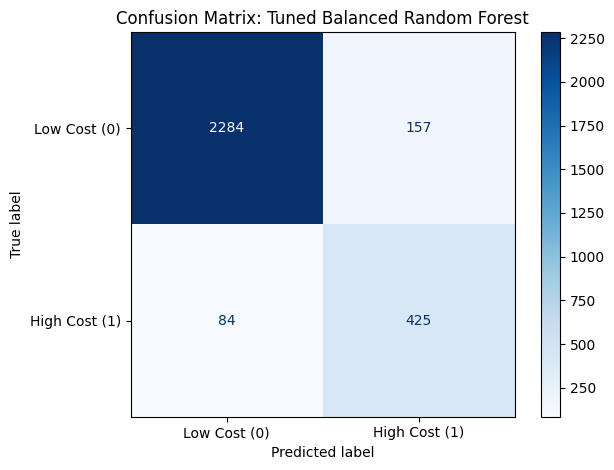

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_brf)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Cost (0)", "High Cost (1)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Tuned Balanced Random Forest")
plt.tight_layout()
plt.show()

# Change In Parameters


📋 Classification Report (Tuned Balanced Random Forest):

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2441
           1       0.76      0.82      0.79       509

    accuracy                           0.92      2950
   macro avg       0.86      0.88      0.87      2950
weighted avg       0.93      0.92      0.93      2950



<ipython-input-31-a1727a72c5ce>:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=class_importance.head(10), palette='Reds_r')


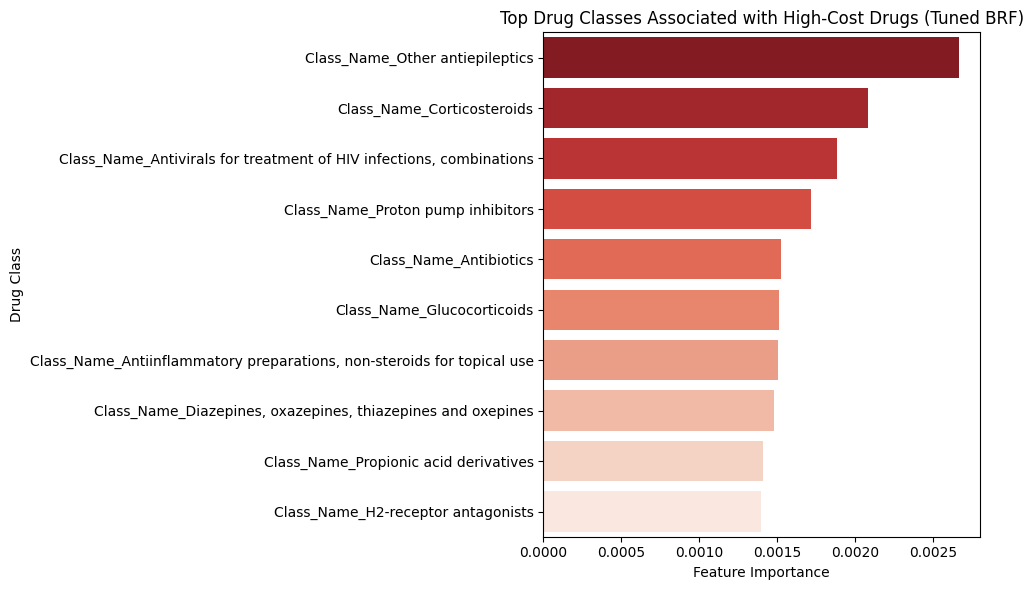

<ipython-input-31-a1727a72c5ce>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=mftr_importance.head(10), palette='Blues_r')


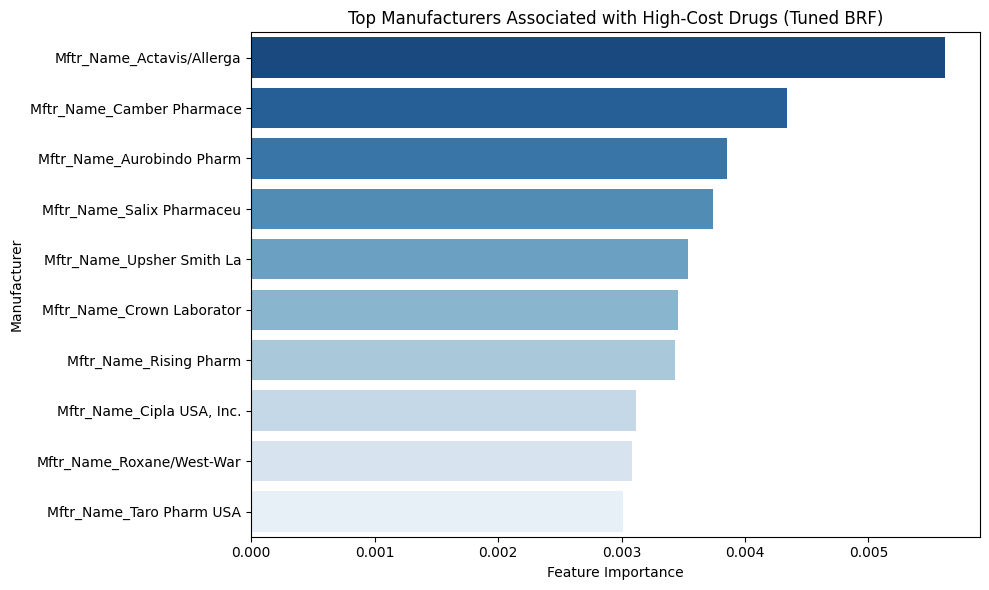

<ipython-input-31-a1727a72c5ce>:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=gnrc_importance.head(10), palette='Purples_r')


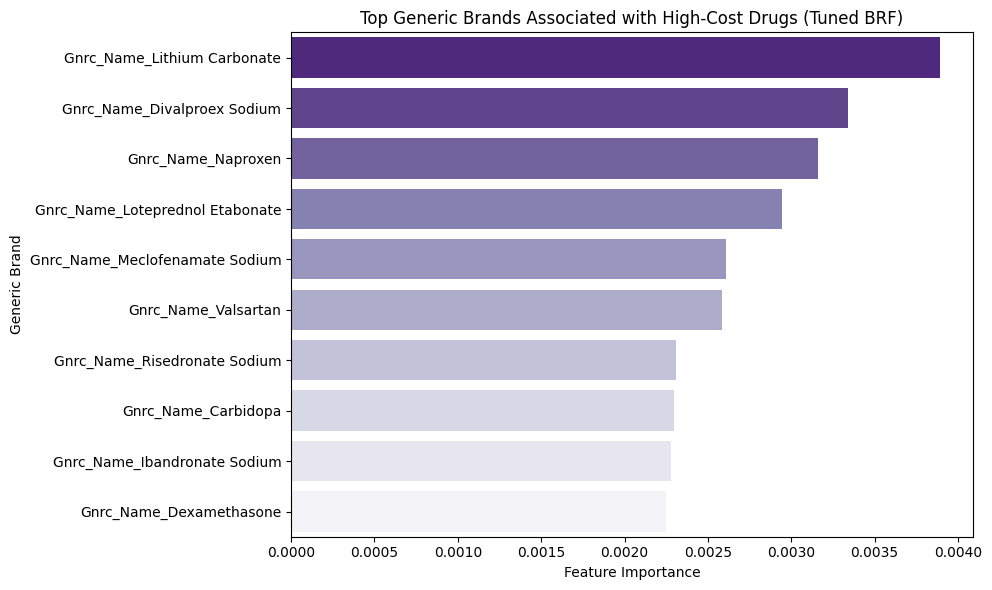

<ipython-input-31-a1727a72c5ce>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=brnd_importance.head(10), palette='Greens_r')


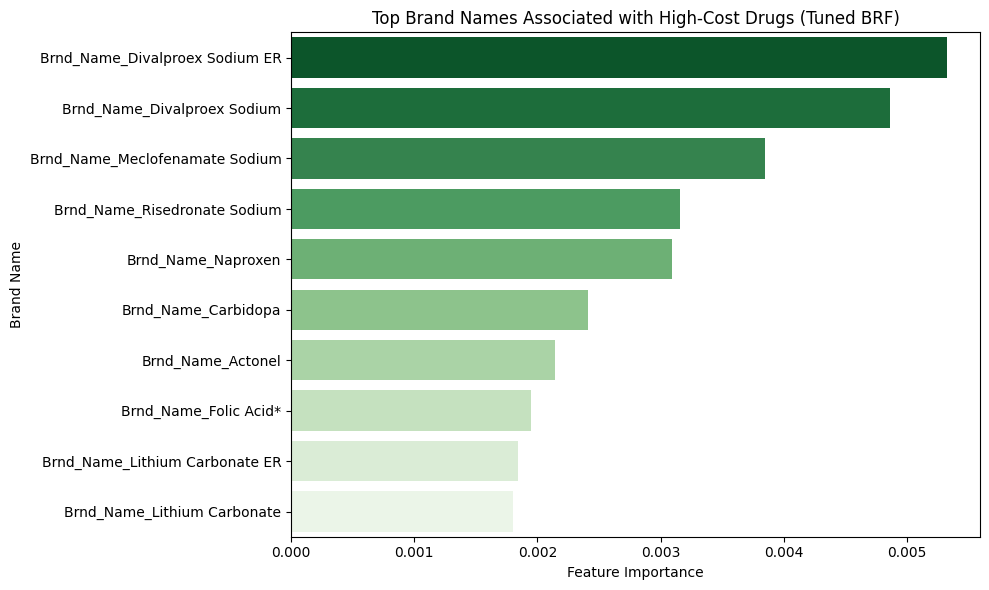

In [ ]:
df = pd.read_csv('full_data.csv')

# Create % increase from 2018 to 2022
df['pct_increase_spending_18_22'] = (
    (df['Avg_Spnd_Per_Clm_2022'] - df['Avg_Spnd_Per_Clm_2018']) /
    df['Avg_Spnd_Per_Clm_2018']
) * 100

df = df.dropna(subset=['pct_increase_spending_18_22'])
df = df[~df['pct_increase_spending_18_22'].isin([float('inf'), -float('inf')])]

threshold = df['pct_increase_spending_18_22'].quantile(0.80)
df['is_high_cost'] = (df['pct_increase_spending_18_22'] >= threshold).astype(int)

# Select and encode features
features = [
    'Tot_Clms_2022',
    'Avg_Spnd_Per_Dsg_Unt_Wghtd_2022',
    'Chg_Avg_Spnd_Per_Dsg_Unt_21_22',
    'Class_Name',
    'Mftr_Name',
    'Gnrc_Name',
    'Brnd_Name'
]
df_model = df[features + ['is_high_cost']].dropna()
df_model = df_model[df_model['Mftr_Name'] != 'Overall']

df_encoded = pd.get_dummies(df_model, columns=['Class_Name', 'Mftr_Name', 'Gnrc_Name', 'Brnd_Name'], drop_first=True)

# Train/test split with scaling
X = df_encoded.drop(columns=['is_high_cost'])
y = df_encoded['is_high_cost']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42, stratify=y
)



# Final Balanced Random Forest with best parameters
brf_final = BalancedRandomForestClassifier(
    n_estimators=250,
    max_depth=None,
    max_features='log2',
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=False,
    random_state=42
)
brf_final.fit(X_train, y_train)
y_pred_final = brf_final.predict(X_test)

# STEP 6: Evaluation
print("\n📋 Classification Report (Tuned Balanced Random Forest):\n")
print(classification_report(y_test, y_pred_final))

# STEP 7: Feature Importance
importances = brf_final.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Split out categories for analysis
class_importance = importance_df[importance_df['feature'].str.startswith('Class_Name_')].sort_values(by='importance', ascending=False)
mftr_importance = importance_df[importance_df['feature'].str.startswith('Mftr_Name_')].sort_values(by='importance', ascending=False)
gnrc_importance = importance_df[importance_df['feature'].str.startswith('Gnrc_Name_')].sort_values(by='importance', ascending=False)
brnd_importance = importance_df[importance_df['feature'].str.startswith('Brnd_Name_')].sort_values(by='importance', ascending=False)

# STEP 8: Plot top drug classes
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=class_importance.head(10), palette='Reds_r')
plt.title("Top Drug Classes Associated with High-Cost Drugs (Tuned BRF)")
plt.xlabel("Feature Importance")
plt.ylabel("Drug Class")
plt.tight_layout()
plt.show()

# STEP 9: Plot top manufacturers
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=mftr_importance.head(10), palette='Blues_r')
plt.title("Top Manufacturers Associated with High-Cost Drugs (Tuned BRF)")
plt.xlabel("Feature Importance")
plt.ylabel("Manufacturer")
plt.tight_layout()
plt.show()

# STEP 10: Plot top generic names
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=gnrc_importance.head(10), palette='Purples_r')
plt.title("Top Generic Brands Associated with High-Cost Drugs (Tuned BRF)")
plt.xlabel("Feature Importance")
plt.ylabel("Generic Brand")
plt.tight_layout()
plt.show()

# STEP 11: Plot top brand names
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=brnd_importance.head(10), palette='Greens_r')
plt.title("Top Brand Names Associated with High-Cost Drugs (Tuned BRF)")
plt.xlabel("Feature Importance")
plt.ylabel("Brand Name")
plt.tight_layout()
plt.show()


In [ ]:
df

,Brnd_Name,Gnrc_Name,Tot_Mftr,Mftr_Name,Tot_Spndng_2018,Tot_Dsg_Unts_2018,Tot_Clms_2018,Tot_Benes_2018,Avg_Spnd_Per_Dsg_Unt_Wghtd_2018,Avg_Spnd_Per_Clm_2018,...,Avg_Spnd_Per_Bene_2022,Outlier_Flag_2022,Chg_Avg_Spnd_Per_Dsg_Unt_21_22,CAGR_Avg_Spnd_Per_Dsg_Unt_18_22,Class_Name,Class_Type,Class_ID,Source,pct_increase_spending_18_22,is_high_cost
0,1st Tier Unifine Pentips,"Pen Needle, Diabetic",1,Overall,167193.78,761658.0,6538.0,2341.0,0.219785,25.572619,...,61.063304,0.0,0.012882,0.006855,NaN,NaN,NaN,NaN,9.510264,0
1,1st Tier Unifine Pentips,"Pen Needle, Diabetic",1,Owen Mumford Us,167193.78,761658.0,6538.0,2341.0,0.219785,25.572619,...,61.063304,0.0,0.012882,0.006855,NaN,NaN,NaN,NaN,9.510264,0
2,1st Tier Unifine Pentips Plus,"Pen Needle, Diabetic",1,Overall,369402.85,1813908.0,14931.0,5674.0,0.203658,24.740664,...,77.748670,0.0,0.012441,0.037214,NaN,NaN,NaN,NaN,20.439745,0
3,1st Tier Unifine Pentips Plus,"Pen Needle, Diabetic",1,Owen Mumford Us,369402.85,1813908.0,14931.0,5674.0,0.203658,24.740664,...,77.748670,0.0,0.012441,0.037214,NaN,NaN,NaN,NaN,20.439745,0
4,Abacavir,Abacavir Sulfate,6,Overall,10653423.32,3034767.0,40388.0,7359.0,4.032155,263.776947,...,2012.040472,0.0,0.214564,-0.010130,Nucleoside and nucleotide reverse transcriptas...,ATC1-4,J05AF,ATC,8.283097,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24980,Zyvox,Linezolid,1,Overall,860973.30,6628.0,165.0,126.0,203.867879,5218.020000,...,2402.677750,1.0,0.565507,-0.192201,Other antibacterials,ATC1-4,J01XX,ATC,-59.070422,0
24981,Zyvox,Linezolid,1,Pharmaci/Pfizer,860973.30,6628.0,165.0,126.0,203.867879,5218.020000,...,2402.677750,1.0,0.565507,-0.192201,Other antibacterials,ATC1-4,J01XX,ATC,-59.070422,0
24982,Zyvox,Linezolid In Dextrose 5%,2,Overall,192099.15,781318.0,298.0,134.0,0.245353,644.628020,...,817.559474,0.0,0.007745,-0.095281,NaN,NaN,NaN,NaN,-43.960362,0
24983,Zyvox,Linezolid In Dextrose 5%,1,Pharmaci/Pfizer,142560.36,575210.0,199.0,90.0,0.247841,716.383719,...,673.596667,0.0,-0.011061,-0.100714,NaN,NaN,NaN,NaN,-50.220812,0


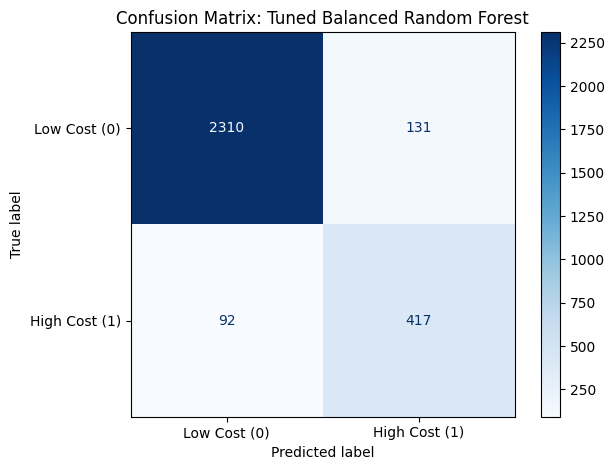

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Cost (0)", "High Cost (1)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Tuned Balanced Random Forest")
plt.tight_layout()
plt.show()

# K-Means Clustering

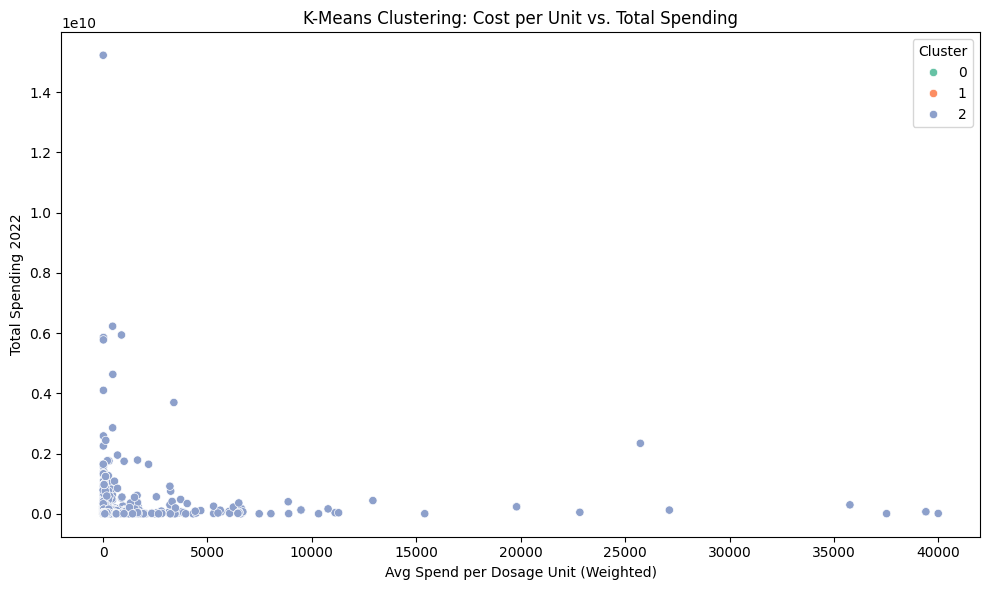


📊 Cluster Summary (Averages):
         Tot_Spndng_2022  Tot_Dsg_Unts_2022  Tot_Clms_2022  \
Cluster                                                      
0           2.392610e+06       5.291396e+06   84913.400000   
1           1.018487e+07       2.426394e+06   17869.416667   
2           1.918772e+07       1.117713e+07  165090.611057   

         Avg_Spnd_Per_Dsg_Unt_Wghtd_2022  Chg_Avg_Spnd_Per_Dsg_Unt_21_22  \
Cluster                                                                    
0                               0.526406                        0.104806   
1                              52.509946                        0.064519   
2                              92.367573                        0.069029   

         Count  
Cluster         
0            5  
1           24  
2        13457  

 Most Common Manufacturer per Cluster:
Cluster
0           Teva USA
1    Aptalis/Allerga
2    Aurobindo Pharm
Name: Mftr_Name, dtype: object

Most Common Drug Class per Cluster:
Cluster
0    

In [ ]:
#  Load and clean dataset
df_full = pd.read_csv("full_data.csv")
df_full = df_full[df_full['Mftr_Name'].str.lower() != 'overall']  # Remove "Overall" manufacturer

# Select relevant features
features = [
    'Tot_Spndng_2022',
    'Tot_Dsg_Unts_2022',
    'Tot_Clms_2022',
    'Avg_Spnd_Per_Dsg_Unt_Wghtd_2022',
    'Chg_Avg_Spnd_Per_Dsg_Unt_21_22',
    'Class_Name',
    'Mftr_Name',
    'Gnrc_Name'
]

df_cluster = df_full[features].dropna()  # Remove missing values

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_cluster, columns=['Class_Name', 'Mftr_Name', 'Gnrc_Name'], drop_first=True)

#Scale numeric + encoded features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

#  Run K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels back to original (raw) DataFrame
df_cluster['Cluster'] = clusters

# Visualize clusters (using unscaled values)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cluster,
    x='Avg_Spnd_Per_Dsg_Unt_Wghtd_2022',
    y='Tot_Spndng_2022',
    hue='Cluster',
    palette='Set2'
)
plt.title('K-Means Clustering: Cost per Unit vs. Total Spending')
plt.xlabel('Avg Spend per Dosage Unit (Weighted)')
plt.ylabel('Total Spending 2022')
plt.tight_layout()
plt.show()

# Interpret clusters — Numeric summary
cluster_summary = df_cluster.groupby('Cluster').agg({
    'Tot_Spndng_2022': 'mean',
    'Tot_Dsg_Unts_2022': 'mean',
    'Tot_Clms_2022': 'mean',
    'Avg_Spnd_Per_Dsg_Unt_Wghtd_2022': 'mean',
    'Chg_Avg_Spnd_Per_Dsg_Unt_21_22': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'})

print("\n📊 Cluster Summary (Averages):")
print(cluster_summary)

# Interpret clusters — Most common values
print("\n Most Common Manufacturer per Cluster:")
print(df_cluster.groupby('Cluster')['Mftr_Name'].agg(lambda x: x.value_counts().idxmax()))

print("\nMost Common Drug Class per Cluster:")
print(df_cluster.groupby('Cluster')['Class_Name'].agg(lambda x: x.value_counts().idxmax()))

print("\nMost Common Generic Name per Cluster:")
print(df_cluster.groupby('Cluster')['Gnrc_Name'].agg(lambda x: x.value_counts().idxmax()))


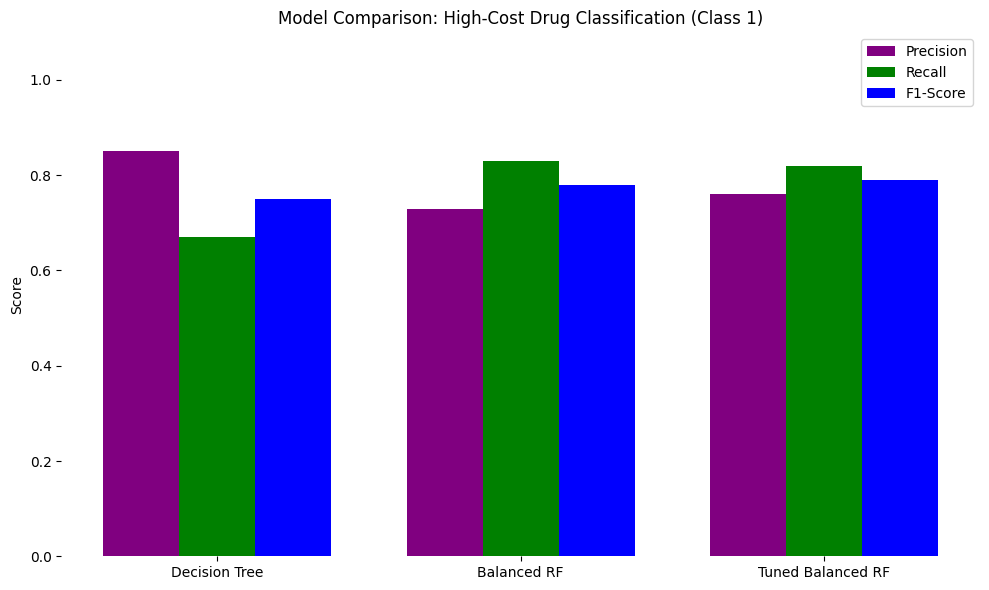

In [ ]:
# Data for the three models
data = {
    "Model": ["Decision Tree", "Balanced RF", "Tuned Balanced RF"],
    "Precision (Class 1)": [0.85, 0.73, 0.76],
    "Recall (Class 1)": [0.67, 0.83, 0.82],
    "F1-Score (Class 1)": [0.75, 0.78, 0.79]
}

# Create DataFrame
df_metrics = pd.DataFrame(data)

# Plot settings
fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')
bar_width = 0.25
index = range(len(df_metrics))

# Create bars for each metric
ax.bar([i - bar_width for i in index], df_metrics["Precision (Class 1)"], width=bar_width, label='Precision', color='purple')
ax.bar(index, df_metrics["Recall (Class 1)"], width=bar_width, label='Recall', color='green')
ax.bar([i + bar_width for i in index], df_metrics["F1-Score (Class 1)"], width=bar_width, label='F1-Score', color='blue')

# Customize axes and labels
ax.set_xticks(index)
ax.set_xticklabels(df_metrics["Model"])
ax.set_ylim(0, 1.1)
ax.set_ylabel("Score")
ax.set_title("Model Comparison: High-Cost Drug Classification (Class 1)")
ax.legend()
fig.patch.set_alpha(0)       # Fully transparent figure background
ax.set_facecolor('none')     # Transparent axes background

# Remove all plot spines (borders)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("model_comparison_transparent.png", transparent=True, dpi=300)  # Optional: save with transparency
plt.show()
